In [95]:
!pip install kagglehub
!pip install segmentation-models-pytorch

In [96]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/kvasir-dataset-for-classification-and-segmentation")

print("Path to dataset files:", path)

100%|██████████| 1.20G/1.20G [00:12<00:00, 100MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation/versions/1


In [97]:
mv /root/.cache/kagglehub/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation/versions/1 ./

mv: cannot move '/root/.cache/kagglehub/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation/versions/1' to './1': Directory not empty


In [98]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

In [99]:
Image_path = '/content/1/kvasir-seg/Kvasir-SEG/images'
Mask_path = '/content/1/kvasir-seg/Kvasir-SEG/masks'

In [100]:
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [101]:
class segmentationDataset(Dataset):
  def __init__(self, image_paths: list, mask_paths: list, transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = cv2.imread(self.image_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32)
    image /= 255.0

    mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask.astype('float32')
    mask /= 255.0
    mask = np.expand_dims(mask, axis=0)

    image = torch.tensor(image).permute(2, 0, 1)
    mask = torch.tensor(mask)

    return image, mask

In [102]:
image_paths = sorted(glob(os.path.join(Image_path, '*jpg')))
mask_paths = sorted(glob(os.path.join(Mask_path, '*jpg')))

In [103]:
train_images, test_images, train_mask, test_mask = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)

len(train_images), len(test_images), len(train_mask), len(test_mask)

(700, 300, 700, 300)

In [104]:
train_dataset = segmentationDataset(train_images, train_mask)
test_dataset = segmentationDataset(test_images, test_mask)

len(train_dataset), len(test_dataset)

(700, 300)

In [105]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)

(44, 19)

In [106]:
image, mask = train_dataset[0]

In [107]:
print(image.size())
print(mask.size())

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


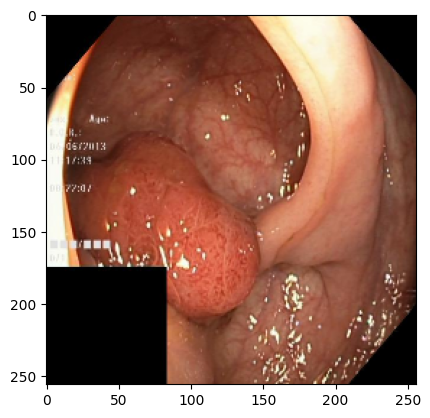

In [108]:
plt.imshow(image.permute(1, 2, 0))
plt.show()

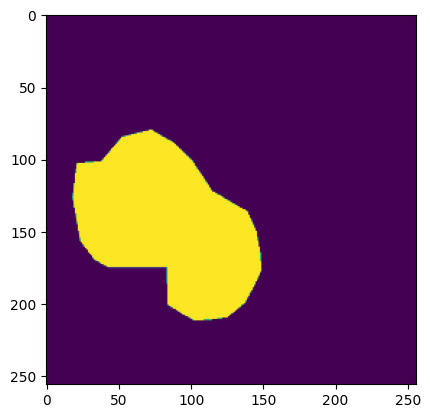

In [109]:
plt.imshow(mask.permute(1,2,0))
plt.show()

## *Model*

https://pypi.org/project/segmentation-models-pytorch/

In [110]:
model = smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', in_channels=3, classes=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training

In [121]:
best_loss = float('inf')
num_epochs = 15

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0

  for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  model.eval()
  test_loss = 0.0

  with torch.no_grad():
    for images, masks in test_loader:
      images = images.to(device)
      masks = masks.to(device)

      outputs = model(images)
      loss = criterion(outputs, masks)
      test_loss += loss.item()

  train_loss /= len(train_loader)
  test_loss /= len(test_loader)

  print(f'epoch: {epoch+1}/{num_epochs}, train loss: {train_loss}, test loss: {test_loss}')

  if test_loss < best_loss:
    best_loss = test_loss
    torch.save(model.state_dict(), 'best_model.pth')
    print('Model saved!')

epoch: 1/15, train loss: 0.21027550406076692, test loss: 0.29468440068395513
Model saved!
epoch: 2/15, train loss: 0.16301985609937797, test loss: 0.3742626874070418
epoch: 3/15, train loss: 0.16024066219952973, test loss: 0.2125919045586335
Model saved!
epoch: 4/15, train loss: 0.13591242175210605, test loss: 0.18915504060293498
Model saved!
epoch: 5/15, train loss: 0.1124451355161992, test loss: 0.15517739324193253
Model saved!
epoch: 6/15, train loss: 0.10905613834885033, test loss: 0.17279595371923948
epoch: 7/15, train loss: 0.08875394265421412, test loss: 0.18067175973402827
epoch: 8/15, train loss: 0.08181466382335532, test loss: 0.22257757657452634
epoch: 9/15, train loss: 0.08510003391314637, test loss: 0.1492950614345701
Model saved!
epoch: 10/15, train loss: 0.0822239143096588, test loss: 0.17745031612484077
epoch: 11/15, train loss: 0.07047466163269499, test loss: 0.2154593589274507
epoch: 12/15, train loss: 0.07005486925217239, test loss: 0.22008546010444038
epoch: 13/15, 

## Visualizer

In [118]:
def visualize_predictions(model, image_path, mask_image, device):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
  image = cv2.resize(image, (256, 256))
  image = image.astype(np.float32)
  image /= 255.0

  mask_image = cv2.imread(mask_image)
  mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGRA2RGB)
  mask_image = cv2.resize(mask_image, (256, 256))
  mask_image = mask_image.astype(np.float32)
  mask_image /= 255.0

  image_tensor = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
  image_tensor = image_tensor.to(device)

  model.eval()
  with torch.no_grad():
    output = model(image_tensor)
    output = torch.sigmoid(output).cpu().squeeze().numpy()
    output = (output > 0.5).astype(np.uint8)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 4, 1)
  plt.title('Image')
  plt.imshow(image)

  plt.subplot(1, 4, 2)
  plt.title('generatend Mask')
  plt.imshow(output)

  plt.subplot(1, 4, 3)
  plt.title('original Mask')
  plt.imshow(mask_image)

  plt.subplot(1,4 , 4)
  plt.title('overall visual')
  plt.imshow(image)
  plt.imshow(output, cmap='jet', alpha=0.5)

  plt.show()

In [119]:
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-119-97ca0473330f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

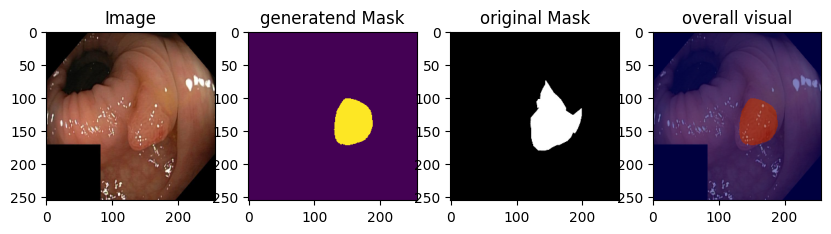

In [120]:
image_name = 'cju0rx1idathl0835detmsp84.jpg'
sample_image = '/content/1/kvasir-seg/Kvasir-SEG/images/'+image_name
mask_image = '/content/1/kvasir-seg/Kvasir-SEG/masks/'+image_name
visualize_predictions(model, sample_image, mask_image, device)